#  Politically Asymmetric Sanctions in Social Media and Misinformation Sharing

Inspired by *Nature's* recent publication: [Mosleh, M., Yang, Q., Zaman, T., Pennycook, G., & Rand, D. G. (2024). Differences in misinformation sharing can lead to politically asymmetric sanctions. Nature, 634, 17 October 2024. https://doi.org/10.1038/s41586-024-07942-8](https://doi.org/10.1038/s41586-024-07942-8).

---

> Evangelia Kapetanaki<br />
> AM: 8210050<br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> Major: Data Analysis and Software Technologies <br />
> t8210050@aueb.gr

* Nowadays, social media platforms are a primary means of communication.

* However, they also play a significant role in the dissemination of misinformation, causing widespread worry.

* Many platforms have implemented policies to combat misinformation, including removing content, flagging false posts, and suspending accounts.

* These attempts have resulted in frequent allegations of political favoritism, especially allegations that conservatives experience unequal enforcement.

* Mosleh et al. (2024) in a recent publication on *Nature* showed that differences in the spread of false information among political orientation groups could lead to differences in suspensions, even when policies are unbiased.

* More specifically, they analyzed $9.000$ Twitter users during the 2020 U.S. election and found that pro-Trump/conservative users were more likely to be suspended than pro-Biden users due to higher rates of sharing low-quality news.

* In this analysis we will replicate some of the methods used to derive these results using statistics with the same dataset that the authors of the article used.


## Setup and Data Inspection

* We start by importing any libraries that will be useful to us in our analysis.

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from scipy.stats import (
    chi2_contingency,
    gaussian_kde,
    norm,
    ttest_ind,
    zscore
)
from scipy.stats.mstats import winsorize
from statsmodels.discrete.discrete_model import Logit, Probit
from statsmodels.stats.multitest import multipletests
from statsmodels.tools import add_constant

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import seaborn as sns

import textwrap

* And we read our data, which are publically available [here](https://osf.io/hy7fz) on The Open Science Framework, a platform for sharing and collaborating on research projects and data.

In [2]:
file_path = "mosleh_et_al_data.csv"

data = pd.read_csv(file_path)

data.head()

,politics_sites2,politics_sites1,politics_followed,lowqual_pr2019_crowd,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,suspended,politics_hashtag,...,valence_neg,valence_neu,valence_pos,politics_sites2_ideo_std,hashtag_ideo_std,barbera_std,politics_sites1_std,repeated_tweet_count,freq_pr_1h,bad_domain_count
0,-0.231902,-1.168745,-0.080295,0.598883,0.279221,0.185315,0.292807,0.350000,0,0,...,0.109935,0.813230,0.076835,0.274317,0.0,0.909460,69,86.0,30,7
1,0.405261,1.060905,2.296375,0.774873,0.848639,0.614156,0.513147,0.975087,0,1,...,0.115985,0.793715,0.090250,0.351800,0.0,0.157056,623,133.0,26,20
2,-0.171067,-0.500076,-2.312730,0.548727,0.242347,0.130950,0.242445,0.300000,0,0,...,0.085765,0.817340,0.096915,0.279591,0.0,0.445349,32,3.0,3,6
3,-0.085814,-0.748035,-1.507481,0.611501,0.360119,0.180055,0.277793,0.316038,0,0,...,0.108680,0.781135,0.110190,0.290277,0.0,0.256665,55,104.0,29,22
4,0.595367,1.347730,2.010573,0.700217,0.698661,0.430655,0.554609,0.763889,0,1,...,0.065145,0.860550,0.074320,0.300823,0.0,0.431149,37,36.0,8,8


* At first glance our data may not be so clear in their content.

* So let's inspect them a bit more.

In [3]:
print(data.shape)
data['politics_hashtag'].value_counts()

(9000, 42)


politics_hashtag
1    4505
0    4495
Name: count, dtype: int64

* We see that we have $9.000$ rows, which correspond to Twitter users.

* From these $9.000$ users, about $4.500$ have used (*#Trump2020*) and about $4.500$ have used (*#VoteBidenHarris2020*).

More specifically according to the article:

* The researchers identified Twitter users who had used the hashtags *#Trump2020* or *#VoteBidenHarris2020* on October 6, 2020 ($100.000$).

* Randomly selected $34,920$ users and collected their $3.200$ most recent tweets.

* After filtering for users who shared at least $5$ links to news websites, the dataset had $12.238$ users.

* Then, $426$ "elite users" with over $15.000$ followers were removed.

* Lastly about $4.500$ users were randomly selected from each political group, creating an equal and representative sample of $9.000$ users.

Let's now look into our columns.

In [4]:
data.columns

Index(['politics_sites2', 'politics_sites1', 'politics_followed',
       'lowqual_pr2019_crowd', 'lowqual_pr2019_fc', 'lowqual_afm',
       'lowqual_mbfc', 'lowqual_lasser2019', 'suspended', 'politics_hashtag',
       'lowqual_pr2019_crowdrep', 'num_followers', 'num_friends',
       'tweets_in_2wk', 'botsentinel_score', 'rewire_abuse', 'rewire_hate',
       'rewire_profanity', 'rewire_violent', 'rewire_sexually_explicit',
       'jigsaw_toxicity', 'jigsaw_severe_toxicity', 'jigsaw_idenity_attack',
       'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat',
       'rocklage_valence_std', 'rocklage_extremity_std',
       'rocklage_emotionality_std', 'rocklage_certainty_std', 'liwc_political',
       'moral_outrage', 'valence_neg', 'valence_neu', 'valence_pos',
       'politics_sites2_ideo_std', 'hashtag_ideo_std', 'barbera_std',
       'politics_sites1_std', 'repeated_tweet_count', 'freq_pr_1h',
       'bad_domain_count'],
      dtype='object')

* Our dataset includes several categories of variables/columns that provide insights into user behavior, political alignment, and content shared on Twitter.

* Core Columns: The most important columns in our analysis are :
  
    * **Politics Hashtag** (`politics_hashtag`) : political hashtags (*#Trump2020* or *#VoteBidenHarris2020*) used by the user.
    
    * **Suspension** (`suspended`) : whether the user has been suspended.

    * **News quality indicators** (such as `lowqual_pr2019_crowd`) : quality of the news shared by user.

* Other columns we use in our analysis have to do with :
  
    * **Political Orientation** (such as `politics_sites1`) : additional to `politics_hashtag`

    * **Toxicity Metrics** (such as `rewire_hate`) : harmful language in user posts.

    * **Sentiment and Emotion** (such as `valence_neg`) : emotional tone of shared content.

    * **Activity and Influence** (such as `num_followers`) : user activity levels and network size.

Let's also get a summary of our columns.

In [5]:
data.describe(include='all')

,politics_sites2,politics_sites1,politics_followed,lowqual_pr2019_crowd,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,suspended,politics_hashtag,...,valence_neg,valence_neu,valence_pos,politics_sites2_ideo_std,hashtag_ideo_std,barbera_std,politics_sites1_std,repeated_tweet_count,freq_pr_1h,bad_domain_count
count,9000.000000,9000.000000,7965.000000,8945.000000,8945.000000,8998.000000,8999.000000,8999.000000,9000.000000,9000.000000,...,8974.000000,8974.000000,8974.000000,9000.000000,9000.000000,8373.000000,9000.000000,8471.000000,9000.000000,9000.000000
mean,0.111928,0.016998,0.227696,0.637918,0.466415,0.275468,0.413464,0.494095,0.120222,0.500556,...,0.071231,0.835800,0.092969,0.273516,0.037318,0.631783,66.785000,212.252272,17.836222,10.045000
std,0.305400,0.896221,1.559826,0.072139,0.239274,0.115979,0.118111,0.201150,0.325239,0.500027,...,0.020335,0.036666,0.028129,0.070535,0.135399,0.302341,95.101625,444.466650,16.940017,23.239408
min,-0.515800,-2.049115,-2.444294,0.524729,0.071429,0.014881,0.016225,0.006419,0.000000,0.000000,...,0.000000,0.565760,0.000000,0.000000,0.000000,0.000489,4.000000,1.000000,0.000000,0.000000
25%,-0.171652,-0.825691,-1.375251,0.567706,0.235390,0.169242,0.303467,0.321429,0.000000,0.000000,...,0.060176,0.816712,0.077290,0.232173,0.000000,0.358380,20.000000,21.000000,8.000000,1.000000
50%,0.037170,-0.082240,0.831402,0.633167,0.457143,0.245677,0.421450,0.410714,0.000000,1.000000,...,0.071212,0.835818,0.090363,0.275003,0.000000,0.603071,43.000000,69.000000,14.000000,4.000000
75%,0.417229,0.859888,1.701126,0.704621,0.702773,0.383621,0.515771,0.691950,0.000000,1.000000,...,0.081980,0.852244,0.106345,0.322558,0.000000,0.878333,80.000000,187.000000,22.000000,12.000000
max,0.863750,2.672990,2.456834,0.823364,0.989881,0.814544,0.967400,1.000000,1.000000,1.000000,...,0.241860,0.999075,0.367570,0.685976,0.707107,1.880192,2450.000000,5444.000000,234.000000,1160.000000


* We notice that :

    * There are `NaN` values in some columns as not all column counts are equal to $9.000$.
    
    * Some columns have much different variance than others (ex. `repeated_tweet_count` ($std = 95.10$) and `freq_pr_1h` ($std = 444.47$) have significantly higher variances compared to others like `valence_neg` ($std = 0.02$).
    
    * There are wide differences in ranges (ex. `politics_sites2` ranges from $-0.5158$ to $0.8638$ (narrow range), while `repeated_tweet_count` ranges from $4$ to $2.450$ (extremely wide range)).

## Twitter Suspensions after the 2020 Election

* Keeping all the above in mind we will move onto checking whether Trump supporters are getting suspended more than Biden supporters.

* To do that we will use **Crosstabulation** using :
  
    * the `suspended` column ($0/1$ where $0$ : not suspended and $1$ : suspended) ($0$ missing values according to the summary at the previous chapter) and
    * the `politics_hashtag` column ($0/1$ where $0$ : has used *#VoteBidenHarris2020* and $1$ : has used *#Trump2020*)  ($0$ missing values).

In [6]:
crosstab_counts = pd.crosstab(data['politics_hashtag'], data['suspended'])

* We add the percentages of the crosstabulation and we display our results in a table. 

In [7]:
# Adding percentages to the counts
crosstab_percentages = pd.crosstab(data['politics_hashtag'], data['suspended'], normalize='index')

# Merging counts and percentages into a single table
formatted_crosstab = crosstab_counts.astype(str) + " (" + (crosstab_percentages * 100).round(2).astype(str) + "%)"
formatted_crosstab.index = ['Biden Hashtags', 'Trump Hashtags']
formatted_crosstab.columns = ['Not Suspended', 'Suspended']

formatted_crosstab

,Not Suspended,Suspended
Biden Hashtags,4295 (95.55%),200 (4.45%)
Trump Hashtags,3623 (80.42%),882 (19.58%)


* Users with Trump hashtags faced a much higher suspension rate ($19.58\% $) compared to those with Biden hashtags ($4.45\%$), highlighting a potential political asymmetry in suspension.

* We also show the difference in suspension rates in a plot to visualize the situation.

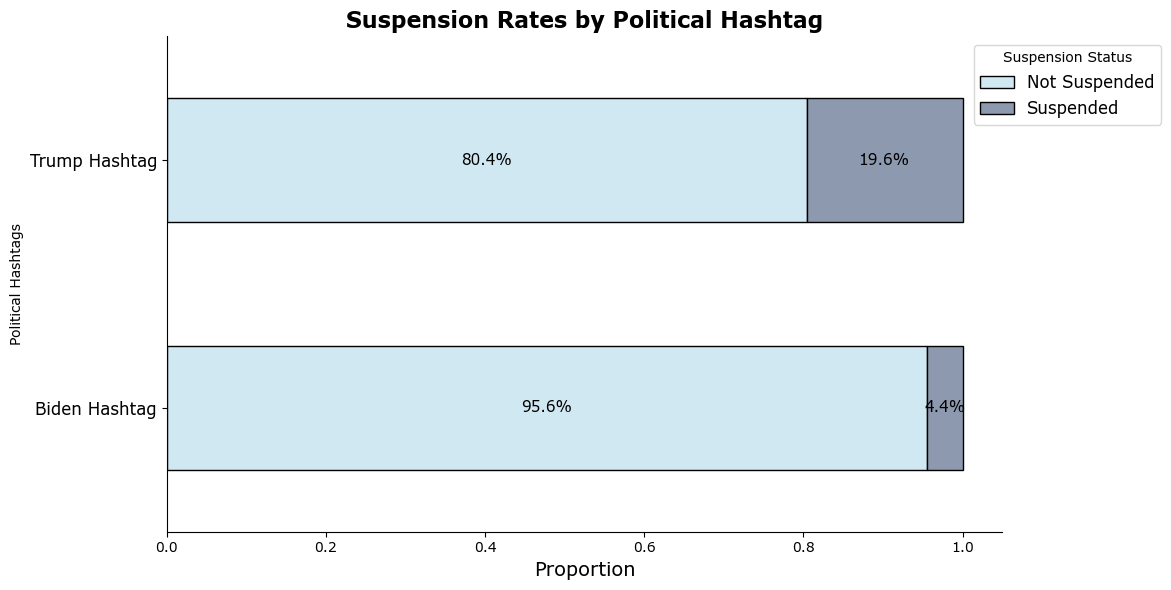

In [8]:
if crosstab_percentages.index.name is not None: # so that it still works if you rerun the code block
    crosstab_percentages = crosstab_percentages.reset_index()
crosstab_percentages.columns = ['Political Hashtags', 'Not Suspended', 'Suspended']

# Stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))
crosstab_percentages.set_index('Political Hashtags').plot.barh(
    stacked=True, color=['#d0e8f2', '#8d99ae'], edgecolor='black', ax=ax
)
ax.set_title("Suspension Rates by Political Hashtag", fontsize=16, weight='bold')
ax.set_xlabel("Proportion", fontsize=14)
ax.legend(title="Suspension Status", fontsize=12, loc='upper right', bbox_to_anchor=(1.2, 1))
ax.set_yticklabels(['Biden Hashtag', 'Trump Hashtag'], fontsize=12)

# Labels inside the bars showing the suspension percentages
for i, row in crosstab_percentages.iterrows():
    ax.text(row['Not Suspended'] / 2, i, f'{row["Not Suspended"]:.1%}', ha='center', va='center', fontsize=11, color='black')
    ax.text(row['Not Suspended'] + row['Suspended'] / 2, i, f'{row["Suspended"]:.1%}', ha='center', va='center', fontsize=11, color='black')

ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

* And we calculate the relative likelihood of suspension.

In [9]:
likelihood = crosstab_counts.loc[1, 1] / crosstab_counts.loc[0, 1] # (1,1): trump-suspension (0,1): biden-suspension

print(f"Likelihood Ratio (Trump/Biden): {likelihood:.1f}")

Likelihood Ratio (Trump/Biden): 4.4


* We see that accounts that shared *#Trump2020* during the election were approximately $4.4$ times more likely to be suspended than the accounts that shared *#VoteBidenHarris2020*.

* It would be incorrect and incomplete to showcase this effect of political hashtag used on suspension on Twitter, without seeing the statistical significance of this difference.

* To do that we will perform a $\chi^2$ test on the contingency table.

   * **$H_0$:** There is no association between the type of hashtag used (Biden vs. Trump) and suspension status.
    
   * **$H_1$:** There exists association between the type of hashtag used (Biden vs. Trump) and suspension status.

In [10]:
chi2, p, dof, expected = chi2_contingency(crosstab_counts)

print("\nChi-squared Test Results:")
print(f"Chi-squared: {chi2:.2f}")
print(f"p-value: {p:.4f}")


Chi-squared Test Results:
Chi-squared: 485.47
p-value: 0.0000


* The $Chi-squared$ statistic measures the discrepancy between the observed frequencies in the contingency table and the frequencies expected under the assumption of no association between the variables. A value of $485.47$ reflects a significant deviation from what would be expected if the variables were independent.

* As $P-Value < 0.0001$ we can conclude that **there is a statistically significant association between political hashtag usage and suspension** and we accept the $H_1$ Hypothesis stated above.

## Distributions of Relative Frequency of Low Quality

* In this chapter we will analyze how low-quality news sharing differs between the $2$ groups defined by political hashtags (*#Trump2020* or *#VoteBidenHarris2020*).

* What want to show **how often different levels of low-quality news sharing occur for each group**.

* To do this, we’ll create a smooth curve (called a **Kernel Density Estimate** or **KDE**) which is like a more precise version of a bar chart, but instead of bars, we use a curve.

* To measure the quality of news we will, for a start, use the column: `lowqual_pr2019_fc` : the ratings of factcheckers on the quality of news websites used by a user.

* But first we must prepare our data.

In [11]:
data['lowqual_pr2019_fc'].isna().sum()

55

* We see that the column we will use has `NaN` values, which could disrupt calculations, so we remove them and put the result on a termorary `DataFrame`.

In [12]:
temp_data_fc = data.dropna(subset=['lowqual_pr2019_fc']).copy()

* After droping the `NaN`s we use standardize the column using `zscore`. $z = \frac{x - \mu}{\sigma}$ ($ z $: The z-score of the data point, $ x $: The individual data point, $ \mu $: The mean of the data, $ \sigma $: The standard deviation of the data)

* This will make the data more comparable between the $2$ groups.

* The z-score indicates how many standard deviations a data point is from the mean. For example $-1$ would mean 1 standard deviation below the mean.

* In our case :
    * Negative $z$-scores mean "higher quality news" (below the mean for low-quality sharing).
    * A $z$-score of $0$ means "medium quality news" (the mean for low-quality sharing).
    * Positive $z$-scores mean "lower quality news" (above the mean for low-quality sharing).


In [13]:
temp_data_fc['lowqual_pr2019_fc_z'] = zscore(temp_data_fc['lowqual_pr2019_fc'])

* Now our data is ready.

* So we move onto ploting the Relative Frequency of Low Quality News Sharing in the two groups.

* We use **Kernel Density Estimation (KDE)** to display the distribution of low-quality sharing scores (z-scores) for two groups: Biden and Trump hashtags. The plot shows **how common each score is in each group**.

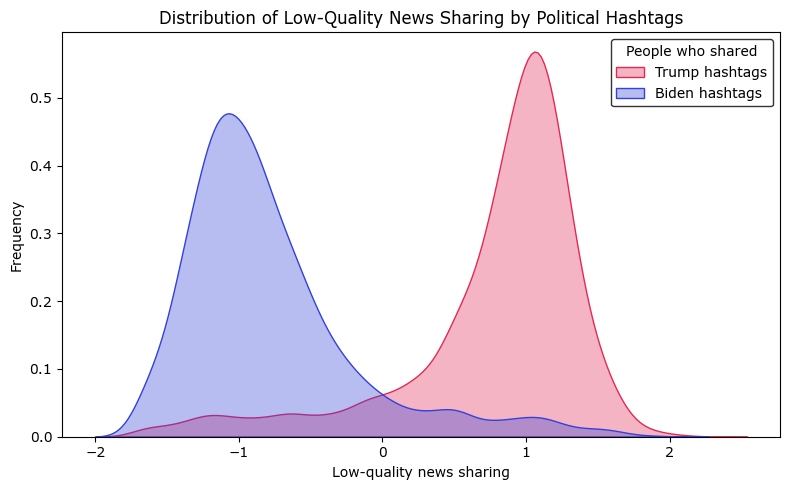

In [14]:
plt.figure(figsize=(8, 5))

sns.kdeplot(
    data=temp_data_fc,
    x="lowqual_pr2019_fc_z",
    hue="politics_hashtag",
    fill=True,
    alpha=0.35,
    palette={1: '#e52853', 0: '#3241d9'}
)
plt.legend(
    title="People who shared",
    loc="upper right",
    frameon=True,
    edgecolor="black",
    labels=["Trump hashtags", "Biden hashtags"]  
)

plt.title("Distribution of Low-Quality News Sharing by Political Hashtags")
plt.xlabel("Low-quality news sharing")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

* Trump's group's distribution peaks sharply in higher scores ($= 1$), suggesting that individuals associated with Trump hashtags are more likely to share low-quality news compared to the Biden hashtag group, whose distribution peaks around lower scores ($= -1$).

* Its important to note that we have very distinct peaks with minimal overlap between the two distributions.

* This means that there is significant behavioral difference in news-sharing tendencies between the two political groups.

* The results seem to be clear on that the Trump hashtag group shares more low - quality news websites (rated by factcheckers).

* But what if fact-checkers had a *"liberal bias"* and the quality ratings of the news websites were biased ?

* To make sure our results are unbiased we will perform the same exact analysis on another column named `lowqual_pr2019_crowd` : the ratings of laypeople on the quality of news websites used by a user (collected from $970$ U.S. laypeople, "quota-matched" for demographics, and averaged across Democrats and Republicans for balance).

In [15]:
data['lowqual_pr2019_crowd'].isna().sum()

55

* We see again that we have `NaN` values in the column we will use. We check if these `NaN`s correspond to the same lines that had `NaN` values in the previous column we used in our analysis.

In [16]:
(data['lowqual_pr2019_fc'].isnull() == data['lowqual_pr2019_crowd'].isnull()).all()

True

* Indeed the two columns have `NaN` values on the same rows.

* Again we remove the `NaN` values from our column.

In [17]:
temp_data_crowd = data.dropna(subset=['lowqual_pr2019_crowd']).copy()

* And we again use $z$-scores to standardize our data of low - quality ratings.

In [18]:
temp_data_crowd['lowqual_pr2019_crowd_z'] = zscore(temp_data_crowd['lowqual_pr2019_crowd'])

* Finally we create the KDE plot again, but this time using the laypeople ratings of low - quality.

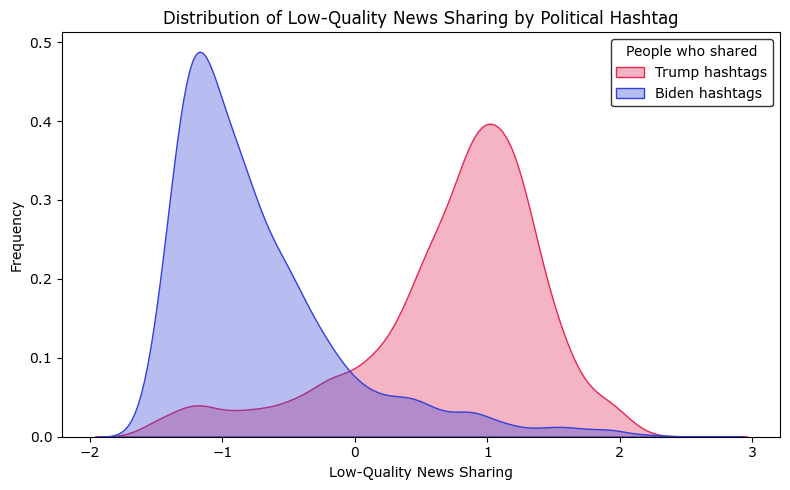

In [19]:
plt.figure(figsize=(8, 5))

sns.kdeplot(
    data=temp_data_crowd,
    x="lowqual_pr2019_crowd_z",
    hue="politics_hashtag",
    fill=True, 
    alpha=0.35,
    palette={0: '#3241d9', 1: '#e52853'}
)
plt.legend(
    title="People who shared",
    loc="upper right",
    frameon=True,
    edgecolor="black",
    labels=["Trump hashtags", "Biden hashtags"],
)

plt.title("Distribution of Low-Quality News Sharing by Political Hashtag")
plt.xlabel("Low-Quality News Sharing")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

* We see that our results are very similar, so fact-checkers were not biased.

* Trump supporters consistently have higher standardized scores for low-quality news sharing compared to Biden supporters, as we have seen in both distributions.

* The crowd-sourced scores reveal slightly more overlap between the groups and a slightly less distinct peak for Trump supporters at low-quality news sharing. However the peaks are still clearly distinct.

* **Both methods confirm a similar overall pattern: Trump supporters share low-quality news more frequently than Biden supporters.**

## Low-quality News Sharing on Twitter

* We will now build upon the previous visual exploration of low-quality news sharing behavior.

* But now we will delve into a quantitative analysis, letting numbers tell us the story.

* We aim to answer the question: "Do Trump and Biden supporters exhibit **statistically significant differences** of behaviors in sharing low-quality news on Twitter?" by these statistical methods:
    
    * Independent samples t-tests to determine statistical differences.
 
    * Calculating effect sizes using Cohen's $d$ and Hedges' $g$ to measure the magnitude of these differences. 

* This time we will analyze $6$ features representing different assessments of low-quality news and not only $2$ like in the previous analysis. The first $2$ variables we will use are the same as before.

  1) `lowqual_pr2019_fc`
  2) `lowqual_pr2019_crowd`
  3) `lowqual_afm`: ratings for 283 news sites provided by [Ad Fontes Media, Inc](https://adfontesmedia.com/).
  4) `lowqual_mbfc`: ratings for 3,216 sites from [Media Bias/Fact Check](https://mediabiasfactcheck.com/).
  5) `lowqual_lasser2019`: ratings for 4,767 sites derived from Lasser et al.'s academic work. (Original source: Lasser, J., et al. *"Social media sharing of low-quality news sources by political elites"* ([DOI : https://doi.org/10.1093/pnasnexus/pgac186](https://doi.org/10.1093/pnasnexus/pgac186))
  7) `lowqual_pr2019_crowdrep`: ratings specifically from Republican participants in the crowd-sourcing study of 971 participants.


In [20]:
low_q_columns = [
    'lowqual_pr2019_fc',
    'lowqual_afm',
    'lowqual_mbfc',
    'lowqual_lasser2019',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]

* We define Cohen's $d$ and Hedges' $g$ in functions since they don't exist in libraries and we will be using them many times.

### Cohen's $d$

* Cohen's $d$ is a widely used measure of effect size in statistics.

* It is calculated as the difference between the two group means, divided by their pooled standard deviation (which combines the variances of the two groups, weighted by their sample sizes).

In [21]:
def calculate_cohen_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)  # Variance
    pooled_std = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) # Pooled variance
    if pooled_std == 0:  # Avoid division by zero
        return 0
    return (np.mean(x1) - np.mean(x2)) / pooled_std

* $d = [0, 2]$

* A small effect starts at $d = 0.20$ and large effects start at $d = 0.80$ which shows important distinctions between the groups.

* We define a function that will interpret the Cohen's $d$ result according to the widely accepted limits for this purpose.

In [22]:
def interpret_cohens_d(d):
    if abs(d) < 0.01:
        return "Very small"
    elif abs(d) < 0.20:
        return "Small"
    elif abs(d) < 0.50:
        return "Medium"
    elif abs(d) < 0.80:
        return "Large"
    elif abs(d) < 1.20:
        return "Very large"
    else:
        return "Huge"

### Hedge's $G$

* While Cohen's $d$ is effective, it may be biased when sample sizes are small. Hedges' $g$ addresses this issue by applying a correction factor.

In [23]:
def calculate_hedges_g(d, n1, n2):
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    return d * correction

### Analysis

* We create a dictionary that will store our results

In [24]:
results = {}

* We want to run t-tests, Cohen's $d$ and Hedges' $G$ on all of our $6$ features/columns seperately so we use a for loop.

* To perform valid statistical comparisons, we need to clean the data from `NaNs` and split it into groups based on `politics_hashtag`.

In [25]:
for col in low_q_columns:
    # Drop NaNs of 'politics_hashtag'
    clean_data = data.dropna(subset=[col, 'politics_hashtag'])
    
    # Groups based on 'politics_hashtag'
    group_biden = clean_data[clean_data['politics_hashtag'] == 0][col]
    group_trump = clean_data[clean_data['politics_hashtag'] == 1][col]
    
    # t-test
    t_stat, p_value = ttest_ind(group_trump, group_biden, equal_var=False)  # Reversed order for t-test
    
    # Cohen's d and Hedges' g
    d = calculate_cohen_d(group_trump, group_biden)
    g = calculate_hedges_g(d, len(group_trump), len(group_biden))
    
    results[col] = {
        'T-statistic': f"{t_stat:.2f}",
        'P-value': f"{p_value:.4f}",
        "Cohen's d": f"{d:.2f}",
        "Effect Size (d)": interpret_cohens_d(d),
        "Hedges' g": f"{g:.2f}"
    }

results_df = pd.DataFrame(results).T # for better readability
results_df

,T-statistic,P-value,Cohen's d,Effect Size (d),Hedges' g
lowqual_pr2019_fc,119.25,0.0000,2.52,Huge,2.52
lowqual_afm,102.71,0.0000,2.16,Huge,2.16
lowqual_mbfc,97.58,0.0000,2.06,Huge,2.06
lowqual_lasser2019,102.68,0.0000,2.16,Huge,2.16
lowqual_pr2019_crowd,102.50,0.0000,2.17,Huge,2.17
lowqual_pr2019_crowdrep,61.08,0.0000,1.29,Huge,1.29


* The T-statistic values are high across all features, indicating a substantial difference in means between the two groups.

* All P-values are $0.0000$, which confirms that the observed differences are statistically significant, so our results did not occur by chance.

* The Cohen's $d$ values are all greater than $2.0$ for most features, indicating a huge effect size. For `lowqual_pr2019_crowdrep`, $d = 1.29$ , which is still considered a huge effect but relatively smaller compared to other features.

* Hedges' $g$ values are equal to Cohen's $d$.

The results consistently show **significant and statistically important differences in low-quality news sharing behavior, with the Trump hashtag group sharing more low-quality news**

# Sharing Lower-quality News Sources and Conservative Ideology

* Let's dive a bit deeper building on top of the previous question.

* We again will again examine the relationships between low-quality news engagement and political ideology indicators.

* But this time we will use in addition to `politics_hashtag`, other political ideology measures, including `politics_followed`, `politics_sites1`, and `politics_sites2`.

* So let's keep these variables in a group called `political_columns`.

In [26]:
political_columns = [
    'politics_followed',
    'politics_hashtag',
    'politics_sites1',
    'politics_sites2'
]

* The `politics_followed` column:
  
    *  Works by looking at the Twitter accounts people choose to follow.
      
    *  Since people often follow others who share their beliefs (a phenomenon called *Ideological Homophily*), it uses this pattern to estimate where someone falls on a scale from liberal to conservative based on who he / she follows.
 
    *  The model of this estimation was derived from the study *"Tweeting from left to right: Is online political communication more than an echo chamber?"* by Barberá, P.,et al. ([DOI: https://doi.org/10.1177/0956797615594620](https://doi.org/10.1177/0956797615594620))

* The `politics_sites1` and `politics_sites2` columns:
  
    * Works by looking at users' shared URLs.
    
    * Assigns users an ideological score (extreme left to extreme right) based on the URLs they shared, which reflect the political leanings of news sources (liberal or conservative). 

    * The models of these estimations were derived from the studies *"Fake news on Twitter during the 2016 U.S. presidential election"* ([DOI: 10.1126/science.aau2706](https://www.science.org/doi/10.1126/science.aau2706)) and *"News Sharing on Social Media"* ([DOI: 10.31219/osf.io/ch8gj](https://osf.io/preprints/osf/ch8gj))* accordingly.

* For low quality news variables we will use the `low_q_columns` we used in the previous chapter.

* Since we want to measure the relationship strength we will use the **Pearson Correlation Coefficient $r$**, for all pairwise relationships between the variables we have for low quality news and political orientation.

In [27]:
correlation_data = data[low_q_columns + political_columns]
correlation_matrix = correlation_data.corr()
correlation_matrix

,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,lowqual_pr2019_crowd,lowqual_pr2019_crowdrep,politics_followed,politics_hashtag,politics_sites1,politics_sites2
lowqual_pr2019_fc,1.000000,0.881299,0.755974,0.859959,0.964348,0.789817,0.809501,0.783463,0.876237,0.854197
lowqual_afm,0.881299,1.000000,0.784055,0.900902,0.854943,0.695761,0.768887,0.734562,0.845285,0.833632
lowqual_mbfc,0.755974,0.784055,1.000000,0.803178,0.713212,0.547665,0.748146,0.717101,0.774779,0.774266
lowqual_lasser2019,0.859959,0.900902,0.803178,1.000000,0.840018,0.671775,0.777250,0.734398,0.835576,0.851794
lowqual_pr2019_crowd,0.964348,0.854943,0.713212,0.840018,1.000000,0.886781,0.754001,0.734856,0.811904,0.784861
lowqual_pr2019_crowdrep,0.789817,0.695761,0.547665,0.671775,0.886781,1.000000,0.540993,0.542505,0.576336,0.552613
politics_followed,0.809501,0.768887,0.748146,0.777250,0.754001,0.540993,1.000000,0.859692,0.878668,0.860106
politics_hashtag,0.783463,0.734562,0.717101,0.734398,0.734856,0.542505,0.859692,1.000000,0.830136,0.812912
politics_sites1,0.876237,0.845285,0.774779,0.835576,0.811904,0.576336,0.878668,0.830136,1.000000,0.933718
politics_sites2,0.854197,0.833632,0.774266,0.851794,0.784861,0.552613,0.860106,0.812912,0.933718,1.000000


* To understand the pairwise correlations we will visualize them in a heatmap using light green for low correlation and dark blue for high correlation.

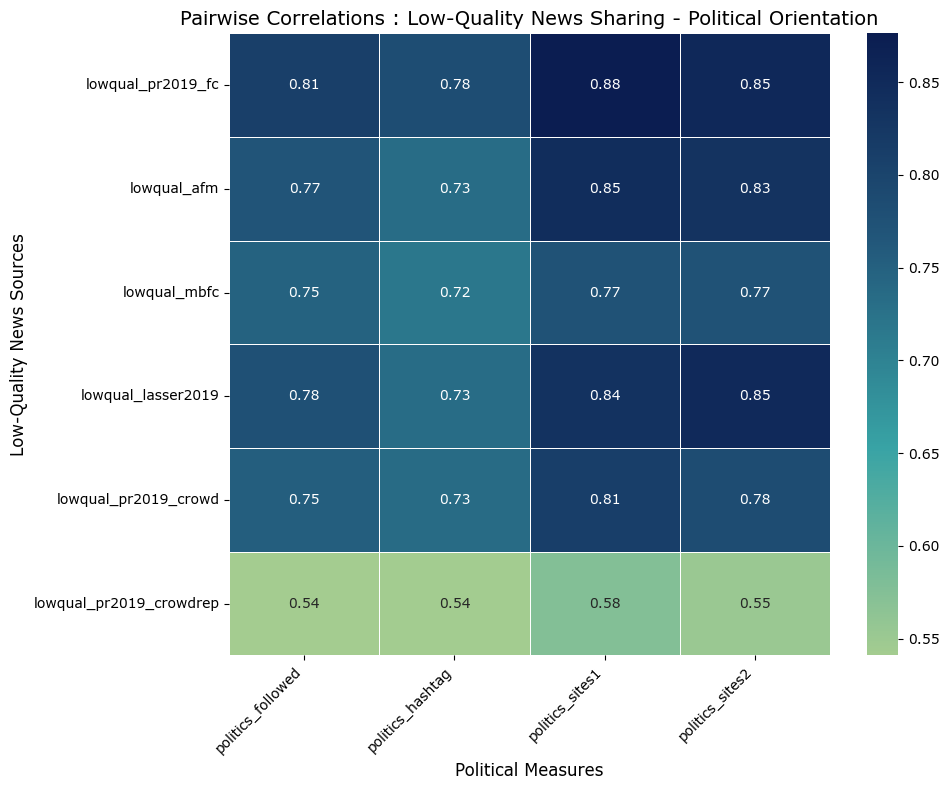

In [28]:
colors = ["#A4CC90", "#38A3A5", "#22577A", "#0B1D51"] # From light green to dark blue palette
custom_cmap = LinearSegmentedColormap.from_list("green_blue", colors) # in gradient

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix.loc[low_q_columns, political_columns],
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,  # Use the custom pallete
    cbar=True,
    linewidths=0.5
)
plt.title("Pairwise Correlations : Low-Quality News Sharing - Political Orientation", fontsize=14)
plt.xlabel("Political Measures", fontsize=12)
plt.ylabel("Low-Quality News Sources", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

* We generally notice strong correlations between politics and low-quality news with values like $r = 0.72 - 0.88$ appearing a lot in the pairwise correlations.
    * This is an indicator that republicans (high values of politics variables) are more likely to engage with low-quality news sources (high values of low - quality news variables).
      
    * Liberals on the other hand seem to be less associated with such engagement.

* However the last row of our heatmap (`lowqual_pr2019_crowdrep`) shows that republican participants’ trustworthiness ratings deviate from broader political behaviors, since we see  $r = 0.54 - 0.58$ - much lower than the general picture.
    * This suggests that Republicans may not always recognize news sources identified by professionals or the general public as "fake news" as being "fake news".
    
    * This can contribute to their higher likelihood of posting, reposting, or sharing such unreliable news sources, which was higher than liberals as we saw before.

## News Sharing Can Help Explain Suspension, Using Single Predictors

* Following the pairwise correlation analysis, we aim to **predict** whether a user was **suspended** using as a set of predictors political behaviors and low-quality news engagement.

* Suspension is a binary outcome ($0 / 1$): suspended or not suspended

* For this reason we will use Probit as our Regression Model to make our predictions

* We will apply Probit Regression $9$ times: once for each predictor.

* To evaluate the predictions of each regression using its Area Under the Curve (AUC) which measures how well a model distinguishes between classes, with high values meaning high quality predictions. Also we will run each prediction $100$ times to get Confidence Intervals.

* We start by defining predictors and the target variable.

In [29]:
predictors = [
    'politics_hashtag', 'politics_sites1', 'politics_sites2', 'politics_followed',
    'lowqual_afm', 'lowqual_mbfc', 'lowqual_lasser2019', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd'
]
target = 'suspended'

* Some more preparations: setting up a seed we will use later to ensure reproducibility and initializing a dataframe to store the results.

In [30]:
np.random.seed(10)
results = []

* For each predictor:
  
    1. We remove `NaN` values on the predictor column that would disrupt the model.
    
    2. $100$ times:
        * Randomly sample the data with sample size = dataset size.
          
        * Fit a Probit regression model on sample.
          
        * Predict probabilities ($\hat{Y}$) of getting suspended on the sampled data based on Probit model.
          
        * Calculate the AUC for the predictions: predicted suspension probabilities $(\hat{Y})$ compared to the true suspensions $(Y)$.
      
    3. Find average AUC and confidence intervals

In [31]:
for predictor in predictors:
    # Clean data for predictor
    data_cleaned = data[[predictor, target]].dropna()
    X = add_constant(data_cleaned[[predictor]])
    y = data_cleaned[target]
    
    # Bootstrap for confidence intervals
    bootstrapped_aucs = []
    for r in range(100):  # 100 bootstrap iterations
        # Sample data
        indices = np.random.choice(len(y), len(y), replace=True)
        X_boot, y_boot = X.iloc[indices], y.iloc[indices]

        # Probit model
        model_boot = Probit(y_boot, X_boot).fit(disp=False)
        y_pred_boot = model_boot.predict(X_boot)

        #AUC
        bootstrapped_aucs.append(roc_auc_score(y_boot, y_pred_boot))
    mean_auc = np.mean(bootstrapped_aucs)
    lower_ci = np.percentile(bootstrapped_aucs, 2.5) # Lowest confidence
    upper_ci = np.percentile(bootstrapped_aucs, 97.5) # Highest confidence

    # Add to results
    category = 'Political Orientation' if predictor in predictors[:4] else 'Low-Quality News Sharing'
    results.append({
        'Category': category,
        'Predictor': predictor,
        'Mean AUC': mean_auc,
        'Lower Confidence': lower_ci,
        'Upper Confidence': upper_ci
    })

* Let's now see how we did.

* We put all our results in a dataframe and apply some formatting to make things more readable.

In [32]:
results_df = pd.DataFrame(results)
label_mapping = {
    'politics_hashtag': 'Hashtags Shared',
    'politics_sites1': 'News Sites Shared 1',
    'politics_sites2': 'News Sites Shared 2',
    'politics_followed': 'Accounts Followed',
    'lowqual_afm': 'AFM Ratings',
    'lowqual_mbfc': 'MBFC Ratings',
    'lowqual_lasser2019': 'Lasser Ratings',
    'lowqual_pr2019_fc': 'Fact-Checker Ratings',
    'lowqual_pr2019_crowd': 'Layperson Ratings'
}
results_df['Predictor'] = results_df['Predictor'].map(label_mapping)
styled_results_df = results_df.style.format({col: "{:.2f}" for col in ['Mean AUC', 'Lower Confidence', 'Upper Confidence']})
styled_results_df

,Category,Predictor,Mean AUC,Lower Confidence,Upper Confidence
0,Political Orientation,Hashtags Shared,0.68,0.67,0.69
1,Political Orientation,News Sites Shared 1,0.70,0.69,0.72
2,Political Orientation,News Sites Shared 2,0.71,0.69,0.72
3,Political Orientation,Accounts Followed,0.71,0.70,0.73
4,Low-Quality News Sharing,AFM Ratings,0.72,0.71,0.73
5,Low-Quality News Sharing,MBFC Ratings,0.71,0.69,0.72
6,Low-Quality News Sharing,Lasser Ratings,0.71,0.69,0.72
7,Low-Quality News Sharing,Fact-Checker Ratings,0.70,0.68,0.71
8,Low-Quality News Sharing,Layperson Ratings,0.69,0.67,0.70


* The table shows how well each predictor, like "Hashtags Shared" or "AFM Ratings," can distinguish between suspended and non-suspended users.

* We see that both political behaviors (like Accounts Followed) and low-quality news (like AFM Ratings) are quite strong predictors -but not exceptionally strong- (AUC = $0.69-0.72$) of user suspension having very small differences between them, with AFM Ratings being the most reliable overall (AUC = $0.72$).

* "Layperson Ratings" (AUC = $0.69$) and "Hashtags Shared" (AUC = $0.68$) are weaker predictors.
  
* Also we notice that we have narrow confidence intervals (maximum interval length is $0.03$) so these models are reliable and not overly sensitive to sample variations.

* To visualize our findlings we will now create a bar chart, showing the Mean AUC (Area Under the Curve) for each predictor along with its $95\%$ Confidence Intervals (CIs).

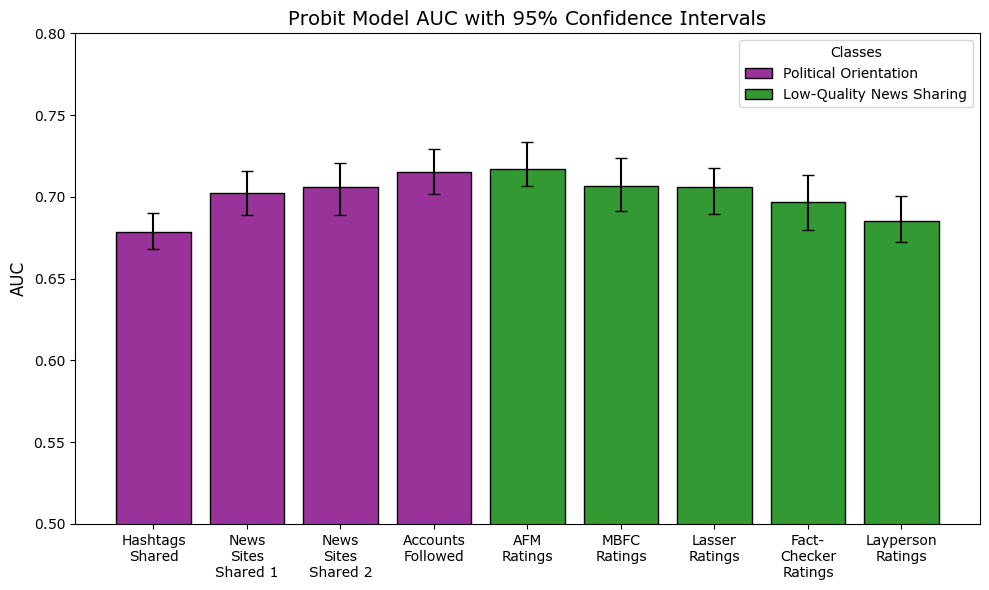

In [33]:
plt.figure(figsize=(10, 6))

categories = ['Political Orientation', 'Low-Quality News Sharing']
colors = {'Political Orientation': '#993399', 'Low-Quality News Sharing': '#339933'} # colour in purple political orient. and in green low q. news

# Format x axis (use text wrapping)
x_positions = range(len(results_df))
max_label_length = 9  # Maximum label length
adjusted_labels = [
    '\n'.join(textwrap.wrap(label, max_label_length)) for label in results_df['Predictor']
]

# Bar Plot
for category in categories:
    subset = results_df[results_df['Category'] == category]
    indices = subset.index
    plt.bar(
        indices,
        subset['Mean AUC'],
        yerr=[subset['Mean AUC'] - subset['Lower Confidence'], subset['Upper Confidence'] - subset['Mean AUC']],
        capsize=4,
        color=colors[category],
        label=category,
        edgecolor='black'
    )

plt.xticks(x_positions, adjusted_labels, fontsize=10, ha='center')
plt.ylim(0.5, 0.8)  # Set Y-axis range
plt.ylabel('AUC', fontsize=12)
plt.title('Probit Model AUC with 95% Confidence Intervals', fontsize=14)
plt.legend(title="Classes", loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

* In our visualization it becomes even clearer that using single predictors' strength it is **not clear whether Political Orientation or Low quality News Sharing are better estimators of suspension**. The mean AUC metrics we are seeing are all in close proximity to each other.

* This blury picture may be because of the **high correlation** these variables have as we saw in previous chapters.

* So maybe using multiple predictor might show a clearer picture.

# News Sharing Can Help Explain Suspension, Using Multiple Predictors


* Let's now examine exactly that: whether using multiple predictors will show as what are the best predictors of Twitter suspension.

* In this analysis we will put all the possible predictor categories we got it our data:
    * **News quality indicators**
    
    * **Political Orientation**
    
    * **Toxicity Metrics** (such as `rewire_hate`) : harmful language in user posts.
    
    * **Sentiment and Emotion** (such as `valence_neg`) : emotional tone of shared content.
    
    * **Activity and Influence** (such as `num_followers`) : user activity levels and network size.
 
* But before we get to the multiple regression (the heart of this analysis) we should do some preparations. 

## Data Preparation

### Missing values

* First of all we must handle the `NaN` values

In [34]:
data.isna().sum().sum()

3418

* We see that we have $3418$ cells that have missing values in our dataset

* We will fill all missing values with the column mean.

In [35]:
data = data.fillna(data.mean())

### Handle outliers

* Handling outliers is also important before moving to a multiple regression.

* Starting off we have some variables (`repeated_tweet_count`, `num_followers`, `num_friends`, `freq_pr_1h`) that represent social or behavioral data, which often follow a long-tailed distribution:
  
   * A majority of users have few tweets or followers.
   * A small number of users dominate with extremely high counts.

* This can be showcased if we show their distribution in boxplots.

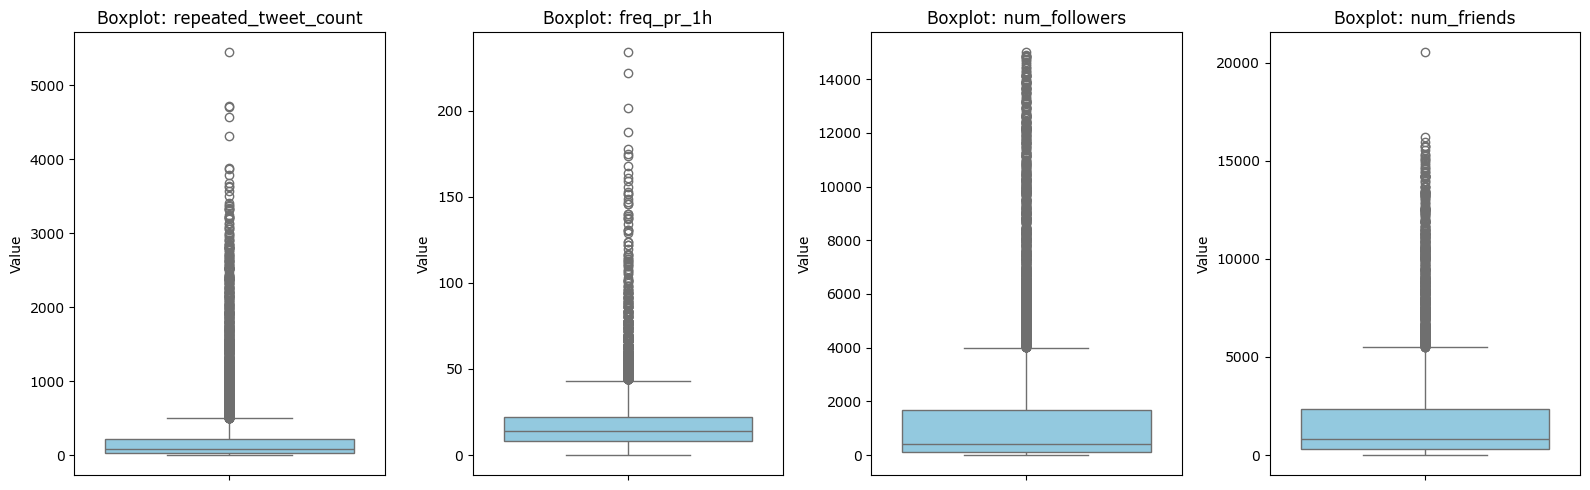

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

# 1 boxplot for each variable
for i, variable in enumerate(["repeated_tweet_count", "freq_pr_1h", "num_followers", "num_friends"]):
    sns.boxplot(data=data[variable], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot: {variable}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Value")
plt.tight_layout()
plt.show()

* We see that distributions show a very concentrated core near the lower end of the scale and a large number of extreme outliers.

* To tackle this issue we will log - transform our data in these columns. (note that we are adding $1$ to avoid $\log_{10}(0)$ which is not defined)

$$
\text{log-transformed value} = \log_{10}(x + 1)
$$


In [37]:
data['log_repeated_tweet_count'] = np.log10(data['repeated_tweet_count'] + 1)
data['log_freq_pr_1h'] = np.log10(data['freq_pr_1h'] + 1)
data['log_num_followers'] = np.log10(data['num_followers'] + 1)
data['log_num_friends'] = np.log10(data['num_friends'] + 1)

* We also create a new variable `log_fol`.
$$\text{Log Followers} = \frac{\log_{10}(\text{Number of Friends} + 1)}{\log_{10}(\text{Number of Followers} + 1)}$$



In [38]:
data['log_fol'] = np.log10((data['num_friends'] + 1) / (data['num_followers'] + 1))

* For other outliers that seem to have a smaller range we will use Winsorization

* For the following variables we will Winsorize for both sides at $99\%$

In [39]:
valence_vars = ['valence_neg', 'valence_neu', 'valence_pos', 
                'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std']
for var in valence_vars:
    data[var] = winsorize(data[var], limits=[0.01, 0.01])

* And for the following variables we will Winsorize for the upper side only at $99\%$

In [40]:
rewire_vars = ['moral_outrage', 'rewire_abuse', 'rewire_hate', 'rewire_profanity', 
               'rewire_violent', 'rewire_sexually_explicit', 'jigsaw_toxicity', 
               'jigsaw_severe_toxicity', 'jigsaw_idenity_attack', 'jigsaw_insult', 
               'jigsaw_profanity', 'jigsaw_threat']
for var in rewire_vars:
    data[var] = winsorize(data[var], limits=[0, 0.01])

### PCA

* Certain variables basically count the same thing (ex. `lowqual_pr2019_fc`, `lowqual_af`', `lowqual_lasser2019`, `lowqual_mbfc` all count low-quality news) so they have a very high correlation between them (which could lead to ***multicollinearity***).

* This could obsure the regression results.

* So to tackle this we will use **PCA** (Principal Component Analysis) to retain most of the information while reducing the number of predictors.

#### PCA for low-quality news sharing

* The first PCA is on the variables `lowqual_pr2019_fc`, `lowqual_af`', `lowqual_lasser2019`, `lowqual_mbfc` all measuring low quality news sharing using different methods.

* We will only keep $1$ component for these variables: a low-quality news sharing index.

* The first step to PCA is standardization ($z-scores$) so we do that with the help of `StandardScaler()`.

In [41]:
scaler = StandardScaler()
low_quality_data_scaled = scaler.fit_transform(data[['lowqual_pr2019_fc', 
                                                     'lowqual_afm', 
                                                     'lowqual_lasser2019', 
                                                     'lowqual_mbfc']])

* We apply PCA on the standarzided columns created a new column, `pc1_misinfo`, which combines the information from the correlated variables into one.

In [42]:
pca_low_quality = PCA(n_components=1)
pc1_misinfo = pca_low_quality.fit_transform(low_quality_data_scaled)
data['pc1_misinfo'] = pc1_misinfo

* Let's see how representative this column is.

In [43]:
pca_low_quality.explained_variance_ratio_

array([0.87255953])

* Se see that $87\%$ of the total variance in the original variables is summarized by PC1.

* Such a high percentage explains why we can use only this single component instead of the original variables.

#### PCA for political orientation

* We will now create one component for the variables `politics_hashtag`, `politics_followed`, `politics_sites1`, `politics_sites2` which all measure political orientation from $0$ (liberal) to $1$ (republican) with different ways (hashtags, accounts followed, shared URLs).

* Again we stardardize our data.

In [44]:
scaler = StandardScaler()
political_data_scaled = scaler.fit_transform(data[['politics_hashtag', 
                                                   'politics_followed', 
                                                   'politics_sites1', 
                                                   'politics_sites2']])

* We apply PCA on the standarzided columns created a new column, `pc1_politics`, which combines the information from the correlated variables into one.

In [45]:
pca_political = PCA(n_components=1)
pc1_politics = pca_political.fit_transform(political_data_scaled)
data['pc1_politics'] = pc1_politics

* And let's check again the explained variance

In [46]:
pca_political.explained_variance_ratio_

array([0.87952937])

* $87\%$ of the total variance in the original variables is summarized by PC1. So again the new variable summarizes the others representatively engough.

In [47]:
print(f"Min: {round(data['pc1_politics'].min(), 2)}, Max: {round(data['pc1_politics'].max(), 2)}")

Min: -3.31, Max: 3.55


* We see that in the new variable $-3$ will be liberal and $3$ will be republican.

* We will add a new variable called `extremity` which will be the absolute value of `pc1_politics`, with $3$ meaning extreme liberal or extreme republican.

In [48]:
data['extremity'] = np.abs(data['pc1_politics'])

#### PCA for follower metrics

* We create $1$ component for the variables `log_num_followers`, `log_num_friends`, `log_fol`.

* Strating again with standardization.

In [49]:
scaler = StandardScaler()
follower_data_scaled = scaler.fit_transform(data[['log_num_followers', 'log_num_friends', 'log_fol']])

* And we name the new variable created by PCA as `pc1_fol`.

In [50]:
pca_follower = PCA(n_components=1)
pc1_fol = pca_follower.fit_transform(follower_data_scaled)
data['pc1_fol'] = pc1_fol

pca_follower.explained_variance_ratio_

array([0.70462969])

* This component explains $70\%$ of the original variables' variance which lower than in the previous PCAs we performed but not too low.

### PCA for harmful language

* Next we will perform PCA on the variables: `rewire_abuse`, `rewire_hate`, `rewire_profanity`, `rewire_violent`, `rewire_sexually_explicit`, `jigsaw_toxicity`, `jigsaw_severe_toxicity`, `jigsaw_idenity_attack`, `jigsaw_insult`, `jigsaw_profanity`, `jigsaw_threat`.

* Here we will use $3$ componets.

* We will later explain why.

* We start by normalizing.

In [51]:
harmful_language_vars = [
    'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent', 
    'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity', 
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]
scaler = StandardScaler()
harmful_language_data_scaled = scaler.fit_transform(data[harmful_language_vars])

* We now perform PCA on these variables for $3$ components.

In [52]:
pca_harmful = PCA(n_components=3)
harmful_language_pca = pca_harmful.fit_transform(harmful_language_data_scaled)
data['pc1_harmful_language'] = harmful_language_pca[:, 0]
data['pc2_harmful_language'] = harmful_language_pca[:, 1]
data['pc3_harmful_language'] = harmful_language_pca[:, 2]

total_explained_variance = pca_harmful.explained_variance_ratio_.sum()
print("Total Explained Variance:", total_explained_variance)
pca_harmful.explained_variance_ratio_

Total Explained Variance: 0.7874157847381195


array([0.5616608 , 0.11871792, 0.10703707])

* The reason we used $3$ components instead of $1$ is that if we had used only $1$ we would have goten only $56\%$ of variance explained, missing valuable information.

* By using $3$ components we get $78.7\%$ explained which is much better.

* This means that we have caught on $3$ different dimensions of variance in the data related to harmful language.

* Let's explore what these dimensions are.

* To do this we will utilize the PCA loading we have.

* Loading shows each variables' contribution to the final value of each PCA.

* For better readbility we round the loadings and present them as percentages of contribution to each PCA.

In [53]:
loadings = (
    pd.DataFrame(
        pca_harmful.components_.T * 100,  # values to percentages
        columns=[
            'Contribution to PC1 (%)',
            'Contribution to PC2 (%)',
            'Contribution to PC3 (%)'
        ],
        index=harmful_language_vars
    )
    .astype(int)  # Convert to integers
)

loadings

,Contribution to PC1 (%),Contribution to PC2 (%),Contribution to PC3 (%)
rewire_abuse,32,34,-30
rewire_hate,23,57,-3
rewire_profanity,25,-23,-43
rewire_violent,23,6,-3
rewire_sexually_explicit,12,-53,-37
jigsaw_toxicity,38,13,-7
jigsaw_severe_toxicity,33,-30,24
jigsaw_idenity_attack,30,-4,46
jigsaw_insult,37,13,-3
jigsaw_profanity,36,-20,-15


* As we said each PCA captures a different dimention of a user's harmful language used on Twitter.

* **PCA1: General Harmful Language**:
    *  Is a **general measure of harmful language intensity**, as it has high positive contributions across almost all variables and captures the majority of the variability in the dataset ($56\%$).
 
    *  The biggest contributors are: toxicity ($38\%$), insult ($37\%$), profanity ($36\%$), severe toxicity ($33\%$), rewire abuse ($32\%$) but all variables have a high contribution.
 
* **PCA2: Hate and Sexually Explicit Language**:
    * Highest positive loading: hate ($58\%$).
      
    * Highest negative loading: sexually explicit language ($-54\%$)
 
    * In real-life this means that these types of harmful language that do not usually occur together, so PCA2 captures this **contrast between hate content and sexually explicit content**.
        
    *  High PCA2 values mean use of hate language unrelated to sexual content. (ex. Twitter posts with hate speech targeting specific groups (like hate-filled political discourse).
     
    *  Low PC2 Scores mean use of sexually explicit content but low levels of hate. (ex. posts containing explicit sexual language, which might not involve hate).

* **PCA3: Targeted harmful behaviour**
    * Highest Positive Contributions: threat ($52\%$), identity attack ($46\%$).
      
    * Highest Negative Contributions: profanity ($-43\%$), sexually explicit language ($-37\%$) .
      
    * PC3 separates **targeted harmful behavior** (threats, identity attacks) from general or sexually explicit profanity.
 
    * High PC3 scores reflect targeted threats or identity-based language
    
    * Low PC3 scores reflect non-targeted vulgar or explicit content.

#### PCA for valence

* Let's now perform PCA with $1$ component for `valence_neg`, `valence_neu` and `valence_pos` which measure the emotional valence of content posted on Twitter by a user.

* [Emotional valence](https://en.wikipedia.org/wiki/Valence_(psychology)) is the sentiment expressed in a piece of content (positive like joy, neutral, or negative like anger).

* Let's start with normalizing the variables.

In [54]:
valence_vars = ['valence_neg', 'valence_neu', 'valence_pos']
scaler = StandardScaler()
valence_data_scaled = scaler.fit_transform(data[valence_vars])

* And we perform PCA and name the new produced variable `pc1_valence`.

In [55]:
pca_valence = PCA(n_components=1)
pc1_valence = pca_valence.fit_transform(valence_data_scaled)
data['pc1_valence'] = pc1_valence
pca_valence.explained_variance_ratio_

array([0.7079432])

* `pc1_valence` captures the $70\%$ of the variability of the original variables.

* It might be interesting to see what exactly this variable measures.

In [56]:
loadings = (
    pd.DataFrame(
        pca_valence.components_[0] * 100,  # values to percentages
        columns=[
            'Contribution to PCA (%)'
        ],
        index=valence_vars
    )
    .astype(int)  # Convert to integers
)
loadings

,Contribution to PCA (%)
valence_neg,-46
valence_neu,68
valence_pos,-56


* This component could represent the degree of neutrality in text content.
  
* High scores: neutral posts (since neutral valence has positive loading).

* Low scores: strongly positively or negatively emotionaly charged posts (since negative valence and positive valence have negative loadings).

### Normalization of variables

* Before we move onto our regression we will define all the independent variables we will use.

In [57]:
independent_vars = [
    'pc1_politics', 'pc1_misinfo', 'pc1_fol', 'pc1_harmful_language', 
    'pc2_harmful_language', 'pc3_harmful_language', 'pc1_valence', 
    'tweets_in_2wk', 'botsentinel_score', 'extremity', 'moral_outrage', 
    'liwc_political', 'log_freq_pr_1h', 'log_repeated_tweet_count', 
    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]

* And normalize them using z-scores.

In [58]:
data[independent_vars] = data[independent_vars].apply(zscore)

## Probit Regression

* And we move to the heart of this chapter: The Regression.

* As we metioned in the beginning of the chapter we will use Probit Regression which is very useful when it comes to binary outcomes ($0/1$) like ours: suspended / not suspended.

* We define our $X$ and $Y$.

In [59]:
X = add_constant(data[independent_vars])
y = data['suspended']

* And we perform Probit regression on our $X$ and $Y$.

In [60]:
probit_model = Probit(y, X).fit()
probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.302637
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                  0.1762
Time:                        15:23:58   Log-Likelihood:                -2723.7
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                3.877e-237
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4273      0.023    -61.086      0.000      -1.473      -1.381
pc1_politics                 0.1341      0.053      2.535      0.011       0.030       0.238
pc1_misinfo                  0.2448      0.046      5.265      0.000       0.154       0.336
pc1_fol                      0.0013      0.021      0.064      0.949      -0.040       0.042
pc1_harmful_language         0.1761      0.026      6.750      0.000       0.125       0.227
pc2_harmful_language        -0.0830      0.026     -3.226      0.001      -0.133      -0.033
pc3_harmful_language        -0.0662      0.021     -3.216      0.001      -0.107      -0.026
pc1_valence                  0.0410      0.023      1.819      0.069      -0.003       0.085
tweets_in_2wk                0.3316      0.021     15.934      0.000       0.291       0.372
botsentinel_score            0.1825      0.039      4.724      0.000       0.107       0.258
extremity                   -0.1199      0.023     -5.295      0.000      -0.164      -0.076
moral_outrage                0.0170      0.034      0.501      0.616      -0.049       0.083
liwc_political              -0.0226      0.029     -0.790      0.429      -0.079       0.033
log_freq_pr_1h               0.1222      0.023      5.351      0.000       0.077       0.167
log_repeated_tweet_count    -0.0074      0.023     -0.326      0.745      -0.052       0.037
barbera_std                 -0.0303      0.024     -1.276      0.202      -0.077       0.016
politics_sites1_std         -0.0259      0.021     -1.224      0.221      -0.067       0.016
politics_sites2_ideo_std     0.0612      0.022      2.752      0.006       0.018       0.105
============================================================================================
"""

* Something to note here is the *"goodness of fit"* of our model.

* We have a pseudo-$R^2=0.17$.

* This might seem quite small but as we have learnt pseudo-$R^2$ can have much smaller values than $R^2$ and values like $0.2-0.4$ can mean that the model is very good.

* In our case $0.17$ is very close to $0.2$ so we can say that we have a good model but maybe not significantly good. However we should keep in mind that we are examining a social phenomenon so a lower pseudo-$R^2$ is expected because of high variability.

* Before going on to interpret our results further we will perform the ***Bonferroni correction*** and the ***Holm-Bonferroni*** correction in p-values to reduce False Positives in our results.

* We will use $a=0.05$ for a threshold of p-values since this is used a lot in social sciences.

In [61]:
alpha = 0.05
p_values = probit_model.pvalues

# Bonferroni correction
reject_bonferroni, bonferroni_p_values, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

# Holm-Bonferroni correction
reject_holm, holm_p_values, _, _ = multipletests(p_values, alpha=alpha, method='holm')

* And we put everything together in a Dataframe with some formating to make things clearer.

In [62]:
coefficients = probit_model.params 
results_df = pd.DataFrame({
    'Variable': p_values.index,
    'Coefficient': coefficients.values,
    'Original P-Value': p_values.values,
    'Bonferroni P-Value': bonferroni_p_values,
    'Holm-Bonferroni P-Value': holm_p_values,
    'Bonferroni Significant (a=0.05)': reject_bonferroni,
    'Holm Significant (a=0.05)': reject_holm
})
for col in ['Original P-Value', 'Bonferroni P-Value', 'Holm-Bonferroni P-Value']:
    results_df[col] = results_df[col].map('{:.4f}'.format)
results_df

,Variable,Coefficient,Original P-Value,Bonferroni P-Value,Holm-Bonferroni P-Value,Bonferroni Significant (a=0.05),Holm Significant (a=0.05)
0,const,-1.427294,0.0000,0.0000,0.0000,True,True
1,pc1_politics,0.134137,0.0112,0.2023,0.0899,False,False
2,pc1_misinfo,0.244822,0.0000,0.0000,0.0000,True,True
3,pc1_fol,0.001340,0.9487,1.0000,1.0000,False,False
4,pc1_harmful_language,0.176119,0.0000,0.0000,0.0000,True,True
5,pc2_harmful_language,-0.082957,0.0013,0.0226,0.0138,True,True
6,pc3_harmful_language,-0.066210,0.0013,0.0234,0.0138,True,True
7,pc1_valence,0.040963,0.0688,1.0000,0.4819,False,False
8,tweets_in_2wk,0.331584,0.0000,0.0000,0.0000,True,True
9,botsentinel_score,0.182463,0.0000,0.0000,0.0000,True,True


* Let's see what are results are.

* (Results are based on the Holm-Bonferroni and Bonferroni p-values.)

**Significant Predictors**

* Predictors are sorted from strongest to weakest predictor.

* Annotation: *: p-value=$0.000$ in both original, Bonferroni and Holm-Bonferroni corrections.

* Very Strong Predictors:

    * `tweets_in_2wk` (coef.=$0.33$*):  High posting frequency.
    
    * `pc1_misinfo` (coef.=$0.24$*):  Posting a lot of misinformation content.
    
    * `botsentinel_score` (coef.=$0.18$*):  Bot-like behavior.
    
    * `pc1_harmful_language` (General Harmful Language) (coef.=$0.17$*):  General harmful language.
      
* Moderately Strong Predictors:

    * `log_freq_pr_1h` (coef.=$0.12$*):  Frequent posting within $1$ hour (spamming).
    
    * `extremity` (coef.=$-0.12$*):  Ideological extremity reduces the likelihood of suspension. This unexpected finding suggests that strongly opinionated posts do not trigger suspension.
    
* Moderate Predictors:
    * `pc2_harmful_language` (High: Hate, Low: Sexually Explicit) (coef.=$-0.08$, p-value < $0.05$):  Sexually explicit content (negative coefficient indicates that as PC2 decreases (more sexually explicit content), the suspension rate increases).
    
    * `pc3_harmful_language` (High: Targeted Profanity, Low: General Profanity) (coef.=$-0.06$, p-value < $0.05$):  General profanity (negative coefficient suggests that lower PC3 scores (more general profanity) increase suspension rates).
    

**Not significant Predictors**

* `pc1_politics`, `pc1_fol`, `pc1_valence`, `moral_outrage`, `log_repeated_tweet_count`,`politics_sites1_std`, `politics_sites2_ideo_std`, `barbera_std` and `liwc_political` are not significant because their p-values (after the corrections)  $> 0.05$.

* Political content, follower-related information, and the sentiment of posts don't seem to be strong predictors of suspension.


**What do the coefficients mean?**

* We sorted the coefficients to get the strength of our predictors.

* But how could we interpret these coefficients?

* Probit model uses the inverse of the cumulative distribution function (CDF) of the standard normal distribution (denoted as $\Phi^{-1}$) as the *link function*.

* $\Phi$ maps a $z$-score to a probability of an event .

* Mathematically, $$ \Phi^{-1}(P(Y = 1 | X)) = X\beta => P(Y = 1 | X) = \Phi(X\beta) $$ where $P(Y = 1 | X)$ is probability of suspension, $X$ the independent variables and $\beta$ the coefficients.

* This means that the probability of suspension is calculated by the $Φ(z)$ where $z = X * \text{coefficients}$.

* Let's use `pc1_misinfo` as an example.

* A $1$-unit increase in `pc1_misinfo` raises the $z$-score (of the suspension probability) by $0.24$ units since that is the value of its coefficient.

* Now if the baseline $( X\beta )$ value (without the increase) corresponds to initial probability: $\Phi(X\beta_{\text{baseline}})$ after increasing `pc1_misinfo` by $1$, the new probability becomes: $\Phi(X\beta_{\text{baseline}}+ 0.24)$.

* <small>(We won't go into details about the exact probability increase as the $Φ$-function has an S-shape. This means the percentage increase in probability depends on the starting point: if the initial probability is $50\%$, the increase will be much bigger compared to when the starting probability is $90\%$)<small>

## Logit Regression

* We saw the predictive strength of our variables using Probit Regression.

* Let's now use Logit Regression to cross-examine our results.

* Logit Regression is also excellent when it comes to binary outcome results $0/1$ like suspension status.

* Having already defined our $X$ and $Y$ earlier in our analysis let's run Logit right away.

In [63]:
logit_model = Logit(y, X).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.303039
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                  0.1751
Time:                        15:23:58   Log-Likelihood:                -2727.3
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                1.380e-235
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5393      0.049    -51.800      0.000      -2.635      -2.443
pc1_politics                 0.2690      0.100      2.680      0.007       0.072       0.466
pc1_misinfo                  0.4692      0.087      5.424      0.000       0.300       0.639
pc1_fol                      0.0019      0.039      0.050      0.960      -0.074       0.078
pc1_harmful_language         0.3050      0.048      6.393      0.000       0.212       0.399
pc2_harmful_language        -0.1467      0.047     -3.147      0.002      -0.238      -0.055
pc3_harmful_language        -0.1162      0.037     -3.162      0.002      -0.188      -0.044
pc1_valence                  0.0700      0.041      1.700      0.089      -0.011       0.151
tweets_in_2wk                0.6133      0.038     16.203      0.000       0.539       0.688
botsentinel_score            0.3502      0.071      4.949      0.000       0.212       0.489
extremity                   -0.2457      0.042     -5.850      0.000      -0.328      -0.163
moral_outrage                0.0437      0.063      0.697      0.486      -0.079       0.166
liwc_political              -0.0594      0.053     -1.123      0.261      -0.163       0.044
log_freq_pr_1h               0.2122      0.042      5.020      0.000       0.129       0.295
log_repeated_tweet_count    -0.0178      0.042     -0.422      0.673      -0.101       0.065
barbera_std                 -0.0591      0.043     -1.371      0.170      -0.144       0.025
politics_sites1_std         -0.0508      0.039     -1.292      0.196      -0.128       0.026
politics_sites2_ideo_std     0.1064      0.041      2.602      0.009       0.026       0.187
============================================================================================
"""

* We note here that *"goodness of fit"* based on pseudo-$R^2=0.17$ the same as in Probit Regression.

* But let's move on to ***Bonferroni correction*** and the ***Holm-Bonferroni*** correction in p-values.

In [64]:
alpha = 0.05
p_values = logit_model.pvalues

# Bonferroni correction
reject_bonferroni, bonferroni_p_values, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

# Holm-Bonferroni correction
reject_holm, holm_p_values, _, _ = multipletests(p_values, alpha=alpha, method='holm')

* And again we put all our results together in a Dataframe with some formating.

In [65]:
coefficients = logit_model.params 
results_df = pd.DataFrame({
    'Variable': p_values.index,
    'Coefficient': coefficients.values,
    'Original P-Value': p_values.values,
    'Bonferroni P-Value': bonferroni_p_values,
    'Holm-Bonferroni P-Value': holm_p_values,
    'Bonferroni Significant (a=0.05)': reject_bonferroni,
    'Holm Significant (a=0.05)': reject_holm
})
for col in ['Original P-Value', 'Bonferroni P-Value', 'Holm-Bonferroni P-Value']:
    results_df[col] = results_df[col].map('{:.4f}'.format)
results_df

,Variable,Coefficient,Original P-Value,Bonferroni P-Value,Holm-Bonferroni P-Value,Bonferroni Significant (a=0.05),Holm Significant (a=0.05)
0,const,-2.539349,0.0000,0.0000,0.0000,True,True
1,pc1_politics,0.269006,0.0074,0.1327,0.0663,False,False
2,pc1_misinfo,0.469216,0.0000,0.0000,0.0000,True,True
3,pc1_fol,0.001930,0.9602,1.0000,1.0000,False,False
4,pc1_harmful_language,0.305038,0.0000,0.0000,0.0000,True,True
5,pc2_harmful_language,-0.146743,0.0016,0.0297,0.0173,True,True
6,pc3_harmful_language,-0.116236,0.0016,0.0282,0.0173,True,True
7,pc1_valence,0.070005,0.0892,1.0000,0.6242,False,False
8,tweets_in_2wk,0.613340,0.0000,0.0000,0.0000,True,True
9,botsentinel_score,0.350171,0.0000,0.0000,0.0000,True,True


* Results are based on the Holm-Bonferroni and Bonferroni p-values.

**Significant Predictors**

* Predictors are sorted from strongest to weakest predictor.

* Annotation: *: p-value=$0.000$ in both original, Bonferroni and Holm-Bonferroni corrections.

* Something important to note here is that now we can interpret our results in a more intuitive way.

* Logit coefficients show how a $1$-unit increase in the predictor affects the **log odds** of suspension. To find the **odds ratio**, we calculate:

$$
\text{Odds Ratio} = e^{\text{coefficient}}
$$

* The odds ratio tells us how much more (or less) likely an event is to occur, expressed as a percentage increase or decrease in odds.

* Very Strong Predictors:

    * `tweets_in_2wk` (coef.=$0.61$*):  
      $e^{0.61} \approx 1.84 \Rightarrow 84\%$ increase in odds.  
    
    * `pc1_misinfo` (coef.=$0.47$*):  
      $e^{0.47} \approx 1.60 \Rightarrow 60\%$ increase in odds.  
    
    * `botsentinel_score` (coef.=$0.35$*):  
      $e^{0.35} \approx 1.42 \Rightarrow 42\%$ increase in odds.  
    
    * `pc1_harmful_language` (coef.=$0.31$*):  
      $e^{0.31} \approx 1.36 \Rightarrow 36\%$ increase in odds.  

* Moderately Strong Predictors:

    * `log_freq_pr_1h` (coef.=$0.21$*):  
      $e^{0.21} \approx 1.23 \Rightarrow 23\%$ increase in odds.  
    
    * `extremity` (coef.=$-0.25$*):  
      $e^{-0.25} \approx 0.78 \Rightarrow 22\%$ decrease in odds.  


* Moderate Predictors:

    * `pc2_harmful_language` (High: Hate, Low: Sexually Explicit) (coef.=$-0.15$, p-value < $0.05$): (reversing hate with sexual explicitness we get coef.: $0.15$) 
      $e^{0.15} \approx 1.16 \Rightarrow 16\%$ increase in odds if a user posts sexually explicit content (low pc2 values).  
    
    * `pc3_harmful_language` (High: Targeted Profanity, Low: General Profanity) (coef.=$-0.12$, p-value < $0.05$): (reversing targeted profanity with general profanity we get coef.: $0.12$) 
      $e^{0.12} \approx 1.12 \Rightarrow 12\%$ increase in odds if a user posts general profanity content (low pc3 values).  
    

**Not significant Predictors**

* `pc1_politics`, `pc1_fol`, `pc1_valence`, `moral_outrage`, `log_repeated_tweet_count`,`politics_sites1_std`, `politics_sites2_ideo_std`, `barbera_std` and `liwc_political` are not significant because their p-values (after the corrections)  $> 0.05$.

* Political content, follower-related information, and the sentiment of posts once again don't seem to be strong predictors of suspension.

## Comparison of Regression Results

* Both Probit and Logit models identify the same significant predictors after Bonferroni and Holm-Bonferroni corrections.

* Both models agree that suspension is primarily predicted by high posting frequency, misinformation content, and bot-like behavior.

* Harmful language, spamming, sexually explicit content, and general profanity are also strong predictors.

* Most importantly for our reasearch, political orientation is not statistically significant in neither of the Regression models.

# Conclusion


* $4$ things are very clear in our research results (for the time period examined: 2020 elections):

    * More Republicans faced suspension on Twitter than Liberals.
 
    * Republicans posted or shared fake news URLs on Twitter more than Liberals.

    * Twitter does not suspend accounts based on their political orientation.
 
    * Twitter targets accounts for suspension that have posted or shared fake news (amongst other criteria).
 
* Based on all this we can safely agree with *Nature's* recent publication ([Mosleh, M., Yang, Q., Zaman, T., Pennycook, G., & Rand, D. G. (2024). Differences in misinformation sharing can lead to politically asymmetric sanctions. Nature, 634, 17 October 2024. https://doi.org/10.1038/s41586-024-07942-8](https://doi.org/10.1038/s41586-024-07942-8)), that the observed politically asymmetric suspensions are driven by differences in misinformation sharing rather than platform bias.

# Note

* The analysis we have performed is very similar to the article's analysis with minor differences (like in some independent variables in our regression models).

* Our results were compared to theirs and were almost the same, showing strong agreement with their findings.